In [1]:
pip install 'monai[all]'

     |████████████████████████████████| 584 kB 14.9 MB/s 
     |████████████████████████████████| 221 kB 26.3 MB/s 
     |████████████████████████████████| 76 kB 2.8 MB/s 
     |████████████████████████████████| 316 kB 25.3 MB/s 
     |████████████████████████████████| 2.9 MB 22.1 MB/s 
     |████████████████████████████████| 68.0 MB 63 kB/s 
     |████████████████████████████████| 36.3 MB 63 kB/s 
     |████████████████████████████████| 14.0 MB 56.1 MB/s 
     |████████████████████████████████| 10.3 MB 41.1 MB/s 
     |████████████████████████████████| 50.1 MB 80 kB/s 
     |████████████████████████████████| 14.4 MB 287 kB/s 
  Created wheel for openslide-python: filename=openslide_python-1.1.2-cp37-cp37m-linux_x86_64.whl size=27700 sha256=6cd406681f3d0b290a34a9053e2ce572a17b50559c17b03a42856b4c0d10e491
  Stored in directory: /root/.cache/pip/wheels/6f/c3/97/980962653f9305314bfb6d93f80be5e21f13e206af66fc7ad3
Successfully built openslide-python
  Attempting uninstall: tqdm
    Found ex

In [2]:
import monai
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import torchvision
import logging
import numpy as np
import pickle
import os
import sys
import joblib
import json
import tempfile
import matplotlib.pyplot as plt

from scipy.special import softmax
from torch.nn import Module
from torch import sigmoid
from sklearn.model_selection import KFold
from sklearn import preprocessing
from monai.data import CacheDataset, DataLoader, Dataset, list_data_collate, ImageDataset, ITKReader, ArrayDataset
from monai.transforms import LoadImageD, EnsureChannelFirstD, AddChannelD, ScaleIntensityD, ToTensorD, Compose, AsDiscreteD, SpacingD, OrientationD, ResizeD, RandAffineD, Activations, Resize
from monai.networks.layers import Norm
from monai.networks.nets import UNet, BasicUNet, VNet
from monai.losses import DiceLoss
from monai.engines import SupervisedTrainer, Trainer, SupervisedEvaluator
from torch.utils.data import DataLoader
from monai.inferers import sliding_window_inference
from monai.handlers import StatsHandler, MeanDice
from monai.transforms.utils import allow_missing_keys_mode
from keras.models import model_from_json, Model
from monai.metrics import DiceMetric
from monai.utils import set_determinism, first
from monai.metrics import compute_meandice
from torch.utils.tensorboard import SummaryWriter
from monai.visualize import plot_2d_or_3d_image
from torch.autograd import Variable
from monai.networks import one_hot

from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    Activations,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
    ScaleIntensityd,
    RandRotate90d,
    MeanEnsemble
)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
pip install import-ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=f0512f2333a219e498881779421a7cfefac4e6d9a497bb938397e5bc19cc0615
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


In [5]:
cd gdrive/MyDrive/Echocardiography_ML_Project_Summer_2021/ 

/content/gdrive/MyDrive/Echocardiography_ML_Project_Summer_2021


In [6]:
import import_ipynb
from KFoldFunction import kFoldSplit

importing Jupyter notebook from KFoldFunction.ipynb


In [7]:
img_list = []

In [8]:
folder_list = []

In [9]:
directory_main = "/content/gdrive/My Drive/Echocardiography_ML_Project_Summer_2021"

In [10]:
directory = "/content/gdrive/My Drive/CAMUS/training"

seg_count = 0
img_count = 0

for folder in os.listdir(directory):
  file_path = directory + '/' + folder
  
  folder_list.append(file_path)
  
  #for file in os.listdir(file_path):

    #if ".mhd" in file and "gt" not in file and "2CH" not in file and "sequence" not in file:
      #file_img = file_path + '/' + file
      #file_path + '/' + file
      
      #print(file_img)
      #img_list.append(file_img)

      #file_img = ''
      #img_count += 1

In [11]:
fold = kFoldSplit(folder_list,0)
print(len(fold['test']),len(fold['train']),len(fold['validation']))

45 360 45


In [12]:
train_set_patients = fold['train']
val_set_patients = fold['validation']

In [31]:
train_set = []
val_set = []

In [32]:
for patient in train_set_patients:
  for file in os.listdir(patient):
    file_str = file.decode("utf-8")

    if ".mhd" in file_str and "gt" not in file_str and "2CH" not in file_str and "sequence" not in file_str:
      file_img = patient + '/' + file_str
    #file_path + '/' + file
    
      #print(file_img)
      train_set.append(file_img)

    #file_img = ''
    #img_count += 1

In [ ]:
for patient in val_set_patients:
  for file in os.listdir(patient):
    file_str = file.decode("utf-8")

    if ".mhd" in file_str and "gt" not in file_str and "2CH" not in file_str and "sequence" not in file_str:
      file_img = patient + '/' + file_str
    #file_path + '/' + file
    
      #print(file_img)
      val_set.append(file_img)

    #file_img = ''
    #img_count += 1

In [ ]:
train_seg_list = [""]*len(train_set)

for i in range(len(train_set)):
  str = (train_set[i])[0:len(train_set[i])-4] + "_gt.mhd"
  train_seg_list[i] = str

val_seg_list = [""]*len(val_set)

for i in range(len(val_set)):
  str = (val_set[i])[0:len(val_set[i])-4] + "_gt.mhd"
  val_seg_list[i] = str

In [ ]:
train_list_data = [{}]*len(train_set)

for i in range(len(train_set)):
  img_label_dict = {'image':train_set[i],'label':train_seg_list[i]}
  
  train_list_data[i] = img_label_dict

In [ ]:
val_list_data = [{}]*len(val_set)

for i in range(len(val_set)):
  img_label_dict = {'image':val_set[i],'label':val_seg_list[i]}
  
  val_list_data[i] = img_label_dict

In [ ]:
len(train_list_data)

720

In [ ]:
train_list_data_truncated = [{}]*30
val_list_data_truncated = [{}]*30

for i in range(0,30):
  train_list_data_truncated[i] = (train_list_data[i])
  val_list_data_truncated[i] = (val_list_data[i])

In [13]:
keys = ['image','label']

transforms = Compose(
    [
     LoadImageD(keys),
     ResizeD(keys,[256,256]),
     ToTensorD(keys)
    ]
)
#try larger batch size
batch_size = 16
num_workers = 4

In [ ]:
ds = Dataset(train_list_data,transforms)
train_loader = DataLoader(ds,batch_size,num_workers)

val_ds = Dataset(val_list_data,transforms)
val_loader = DataLoader(val_ds,batch_size,num_workers)

In [ ]:
for data in val_loader:
  print(data["image"].shape,data["label"].shape)
  break

torch.Size([16, 1, 256, 256]) torch.Size([16, 1, 256, 256])


In [ ]:
device = torch.device('cuda:0')
model = monai.networks.nets.UNet(
    dimensions=2,
    in_channels=1,  
    out_channels=4,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=2,

).to(device)
loss_function = DiceLoss(to_onehot_y=True,softmax=True)#, squared_pred=True)
optimizer = torch.optim.Adam(
    model.parameters(), 1e-3#, weight_decay=1e-5, amsgrad=True
)

In [ ]:
print('Trainable params: {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Trainable params: 6496585


In [ ]:
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
writer = SummaryWriter()
post_label = AsDiscrete(to_onehot=True, n_classes=2)
post_pred = AsDiscrete(argmax=True, to_onehot=True, n_classes=2)

for epoch in range(45):
  print("-" * 45)
  print(f"epoch {epoch + 1}/{45}")
  model.train()
  epoch_loss = 0
  step = 0
  for batch_data in train_loader:
      step += 1
      inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
    
      optimizer.zero_grad()
      
      outputs = model(inputs)
      #outputs = torch.nn.Sigmoid()(outputs)

      loss = loss_function(outputs, labels)
      loss.backward()

      optimizer.step()
      epoch_loss += loss.item()
      epoch_len = len(ds) // train_loader.batch_size
      print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
      writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
  epoch_loss /= step
  epoch_loss_values.append(epoch_loss)
  print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

  if (epoch + 1) % val_interval == 0:
      model.eval()
      with torch.no_grad():
          metric_sum = 0.0
          metric_count = 0

          val_images = None
          val_labels = None
          val_outputs = None

          for val_data in val_loader:

              #print(val_data["image"])
              val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
              
              val_outputs = model(val_images)
              #print("after model",val_outputs.shape,val_outputs)

              val_outputs = torch.nn.Softmax(dim=1)(val_outputs)
              #print("after softmax",val_outputs.shape,val_outputs)

              val_outputs = torch.argmax(val_outputs,dim=1,keepdim=True)
              #print("after argmax",val_outputs.shape,val_outputs)

              #val_outputs = post_trans(val_outputs)
              val_outputs = one_hot(val_outputs,num_classes=4,dim=1)
              #print("after one hot",val_outputs.shape,val_outputs)

              #val_labels = post_trans_label(val_labels)
              val_labels = one_hot(val_labels,num_classes=4,dim=1)

              value = compute_meandice(
                y_pred=val_outputs,
                y=val_labels,
                include_background=True,
              )

              #print("value",value.shape,value)
              
              metric_count += len(value)
              metric_sum += value[:,1,...].sum() 
          metric = metric_sum / metric_count
          metric_values.append(metric)
          if metric > best_metric:
              best_metric = metric
              best_metric_epoch = epoch + 1
              #torch.save(model.state_dict(), root_dir)
              model_name = 'best_segmentation_model_fold_1.pth'
              path = os.path.join(directory_main,model_name)
              torch.save(model.state_dict(),path)

              print("saved new best metric model")
          print(
              "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                  epoch + 1, metric, best_metric, best_metric_epoch
              )
          )

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

---------------------------------------------
epoch 1/45
1/45, train_loss: 0.8158
2/45, train_loss: 0.7987
3/45, train_loss: 0.7987
4/45, train_loss: 0.7858
5/45, train_loss: 0.7868
6/45, train_loss: 0.7782
7/45, train_loss: 0.7741
8/45, train_loss: 0.7707
9/45, train_loss: 0.7564
10/45, train_loss: 0.7646
11/45, train_loss: 0.7569
12/45, train_loss: 0.7642
13/45, train_loss: 0.7525
14/45, train_loss: 0.7456
15/45, train_loss: 0.7482
16/45, train_loss: 0.7453
17/45, train_loss: 0.7483
18/45, train_loss: 0.7478
19/45, train_loss: 0.7471
20/45, train_loss: 0.7427
21/45, train_loss: 0.7464
22/45, train_loss: 0.7339
23/45, train_loss: 0.7280
24/45, train_loss: 0.7281
25/45, train_loss: 0.7362
26/45, train_loss: 0.7382
27/45, train_loss: 0.7223
28/45, train_loss: 0.7299
29/45, train_loss: 0.7458
30/45, train_loss: 0.7241
31/45, train_loss: 0.7202
32/45, train_loss: 0.7065
33/45, train_loss: 0.7316
34/45, train_loss: 0.7260
35/45, train_loss: 0.7158
36/45, train_loss: 0.7180
37/45, train_los

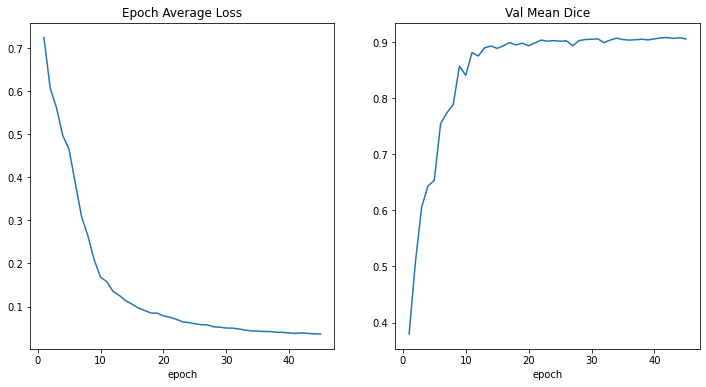

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()